# Seleccion de modelo de cluster

Se llevará a cabo una agrupación de los datos de fenotipo de peces utilizando técnicas no supervisadas de machine learning. Este ejercicio teórico se centra en el uso de clustering no supervisado y no tiene como objetivo separar los datos según especie. Para este propósito, se utilizarían otros modelos supervisados, como por ejemplo un RandomForest.

In [75]:
import pandas as pd

# https://www.kaggle.com/datasets/aungpyaeap/fish-market
df = pd.read_csv(r'C:\Users\GermanBo\Desktop\Kschool\machine learning\Notebooks\Fish.csv')

In [76]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


## Clustering jerarquico

In [77]:
# Tratamiento de datos
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style

# Preprocesado y modelado
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score


In [78]:


def plot_dendrogram(model, **kwargs):
    '''
    Función para representar un dendograma con AgglomerativeClustering
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

In [79]:
# Escalado de datos
X_scaled = scale(df.iloc[:, 1:])


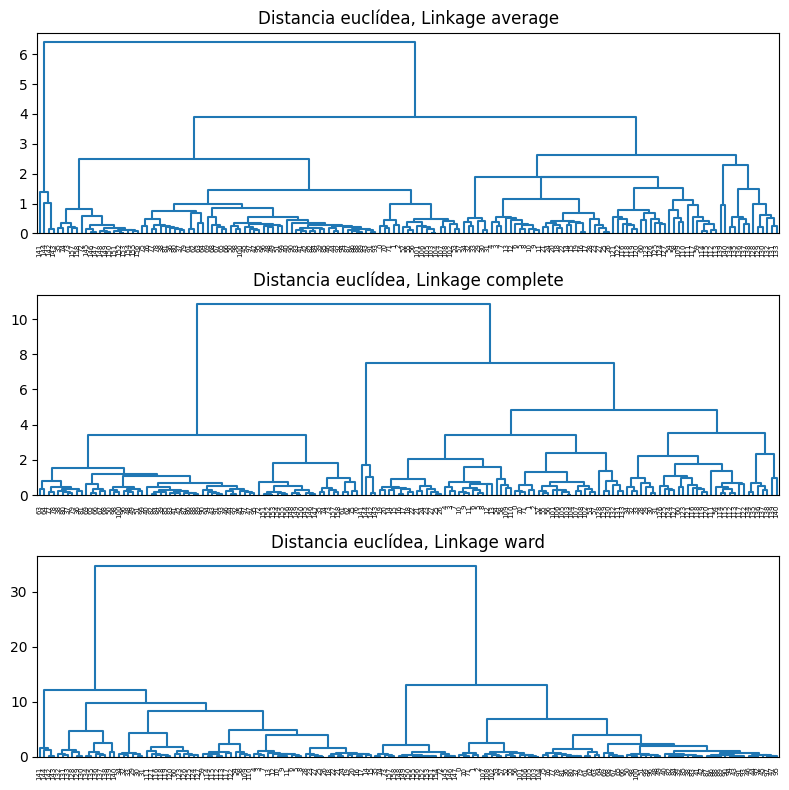

In [97]:
# Modelos
modelo_hclust_complete = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_complete.fit(X=X_scaled)


modelo_hclust_average = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'average',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_average.fit(X=X_scaled)

modelo_hclust_ward = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters         = None
                     )
modelo_hclust_ward.fit(X=X_scaled)


# Dendrogramas
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout();

Una vez ya vemos en su conjunto los dendogramas, vamos a hacer grupos de 7 (el numero de especies que sabemos que tenemos) y veremos que score da con el coeficiente de siluetas 

### Coeficiente de siluetas

In [96]:
# Modelo complete

modelo_hclust_complete = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = None,
                            n_clusters         = 7
                        )
modelo_hclust_complete.fit(X=X_scaled)

coeficiente_silueta = silhouette_score(X_scaled, modelo_hclust_complete.labels_)
print("Coeficiente de silueta 'complete':", coeficiente_silueta)


# Modelo average

modelo_hclust_average = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'average',
                            distance_threshold = None,
                            n_clusters         = 7
                        )
modelo_hclust_average.fit(X=X_scaled)

coeficiente_silueta = silhouette_score(X_scaled, modelo_hclust_average.labels_)
print("Coeficiente de silueta 'average':", coeficiente_silueta)


# Modelo ward

modelo_hclust_ward = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = None,
                            n_clusters         = 7
                     )
modelo_hclust_ward.fit(X=X_scaled)

coeficiente_silueta = silhouette_score(X_scaled, modelo_hclust_ward.labels_)
print("Coeficiente de silueta 'ward':", coeficiente_silueta)

Coeficiente de silueta 'complete': 0.45795529675324453
Coeficiente de silueta 'average': 0.4317525999747764
Coeficiente de silueta 'ward': 0.4298555155461596


Los resultados muestran que son los metodos "complete" y "average" los que obtienen un mejor score. Por ello vamos a obtener los grupos y compararlos segun especies de peces, de uno de los modelos con mejor score

### Obtención de grupos

In [82]:
# Obtener las etiquetas de los grupos
etiquetas_grupos = modelo_hclust_complete.labels_

df['grupo'] = etiquetas_grupos

In [83]:
tabla_contingencia = pd.crosstab(df['Species'], df['grupo'])
tabla_contingencia

grupo,0,1,2,3,4,5,6
Species,,,,,,,
Bream,3,0,25,0,7,0,0
Parkki,2,0,0,2,0,7,0
Perch,8,0,2,5,17,24,0
Pike,6,7,0,0,0,0,4
Roach,2,0,1,1,0,16,0
Smelt,0,0,0,14,0,0,0
Whitefish,3,0,1,0,2,0,0


Vamos a comprar con otro modelo de machine learning no supervisado, como es la agrupacion por K-means

### Modelo K-means

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv(r'C:\Users\GermanBo\Desktop\Kschool\machine learning\Notebooks\Fish.csv')
X_scaled = scale(df.iloc[:, 1:])


# Modelo
modelo_kmeans = KMeans(n_clusters=7, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

y_predict = modelo_kmeans.predict(X=X_scaled)
df['grupo_kmean'] = y_predict

coeficiente_silueta = silhouette_score(X_scaled, y_predict)
print("Coeficiente de silueta de KMeans:", coeficiente_silueta)

Coeficiente de silueta de KMeans: 0.4603502515807795


In [85]:
tabla_contingencia = pd.crosstab(df['Species'], df['grupo_kmean'])
tabla_contingencia

grupo_kmean,0,1,2,3,4,5,6
Species,,,,,,,
Bream,0,0,7,3,0,0,25
Parkki,0,8,0,3,0,0,0
Perch,0,22,17,12,3,0,2
Pike,11,0,0,1,0,5,0
Roach,0,13,0,6,1,0,0
Smelt,0,0,0,0,14,0,0
Whitefish,0,0,2,3,0,0,1


Este resultado seria mejor que el obtenido para el dendrograma , con lo que seria mas interesante el utilizar el este modelo para separar por grupos. Pero, tanto el modelo de dendrograma como la separación por K-Means no logran separar los grupos por especies. Esta falta de coincidencia sugiere que las variables utilizadas por estos modelos para formar los clusters pueden no ser las más adecuadas para diferenciar entre las especies de peces en este conjunto de datos. La clasificación taxonómica de las especies de peces podría estar menos influenciada por las variables proporcionadas en este dataset y más por características genéticas u otros factores que no están reflejados en las variables utilizadas en el análisis de clustering.

#### Optimizacion del numero de grupos por silueta 

Dado esto, se va a buscar obtener la mejor clasificacion de los grupos segun ambos modelos 

### Kmeans

In [86]:

silhouette_scores = []
num_clusters_range = range(2, 11)

# Ajuste del modelo y puntuación para cada numero de grupo
for num_clusters in num_clusters_range:
    modelo_kmeans = KMeans(n_clusters=num_clusters, n_init=25, random_state=123)
    labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    print("num_clusters",num_clusters, "score",silhouette_avg)
    silhouette_scores.append(silhouette_avg)

# Encuentra el número óptimo de clústeres que maximiza la puntuación de silueta
optimal_num_clusters = num_clusters_range[silhouette_scores.index(max(silhouette_scores))]

print("Número óptimo de clústeres:", optimal_num_clusters)

num_clusters 2 score 0.5527418060364624


num_clusters 3 score 0.44720028846627946
num_clusters 4 score 0.46390326401972104
num_clusters 5 score 0.4426271515210892
num_clusters 6 score 0.4977064173652521
num_clusters 7 score 0.4603502515807795
num_clusters 8 score 0.46575360759965373
num_clusters 9 score 0.4713238676917066
num_clusters 10 score 0.47593573105803116
Número óptimo de clústeres: 2


### Dendrograma

In [95]:

silhouette_scores = []
num_clusters_range = range(2, 11)

# Ajuste del modelo y puntuación para cada numero de grupo
for num_clusters in num_clusters_range:
    modelo_hclust_complete = AgglomerativeClustering(
                            metric  = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = None,
                            n_clusters         = num_clusters
                        )
    modelo_hclust_complete.fit(X=X_scaled)
    coeficiente_silueta = silhouette_score(X_scaled, modelo_hclust_complete.labels_)
    silhouette_scores.append(coeficiente_silueta)
    print(num_clusters, coeficiente_silueta)

coeficiente_optimo = num_clusters_range[silhouette_scores.index(max(silhouette_scores))]
print("Coeficiente de silueta 'complete':", coeficiente_optimo)

2 0.49384940800394084
3 0.4841236768276438
4 0.423707598059579
5 0.4286048610610895
6 0.4196753803077938
7 0.45795529675324453
8 0.4596509909094292
9 0.4556837902485868
10 0.47269542229790773
Coeficiente de silueta 'complete': 2


Vemos por tanto que el modelo que separa mejor es el Kmean con solo 2 grupos. 

In [98]:
# Ajustamos el modelo KMeans con el número óptimo de clústeres

modelo_kmeans = KMeans(n_clusters=2, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

y_predict = modelo_kmeans.predict(X=X_scaled)
df['grupo_kmean'] = y_predict

coeficiente_silueta = silhouette_score(X_scaled, y_predict)
print("Coeficiente de silueta de KMeans:", coeficiente_silueta)

Coeficiente de silueta de KMeans: 0.5527418060364624


Por lo tanto, observamos que la forma más efectiva de dividir los datos es utilizando únicamente dos grupos mediante KMeans. Sin embargo, dado que esto es simplemente un ejercicio teórico, no es suficiente para una aplicación práctica. Como se mencionó anteriormente, estos modelos no serían la mejor opción para clasificar según especies, probablemente porque la clasificación de especies no está directamente relacionada con las variables medidas en este contexto.

### Variables mas representantivas

In [106]:
centroides = modelo_kmeans.cluster_centers_

# Crear un DataFrame para visualizar los centroides
df_centroides = pd.DataFrame(centroides, columns=df.iloc[:, 1:7].columns)

# Mostrar los centroides
print("Centroides de los clusters:")
print(df_centroides)


Centroides de los clusters:
     Weight   Length1   Length2   Length3    Height     Width
0 -0.729136 -0.712156 -0.713963 -0.735306 -0.657837 -0.699901
1  0.927044  0.905456  0.907752  0.934889  0.836393  0.889874
